In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

from deepymod_torch.library_function import *
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import *
from deepymod_torch.sparsity import *

torch.set_default_tensor_type('torch.cuda.FloatTensor')

np.random.seed(40)
%load_ext autoreload
%autoreload 2

# Creating data

In [2]:
from scipy.integrate import odeint

In [3]:
data = loadmat('Zener_new.mat')

In [4]:
usol = np.real(data['Expression1'])
usol= usol.reshape((4000,3))

In [36]:
t_v = np.float32(np.expand_dims(usol[:,0],axis=1))
y_stress = np.float32(np.expand_dims(usol[:,2],axis=1))
y_strain = np.float32(np.expand_dims(usol[:,1],axis=1))

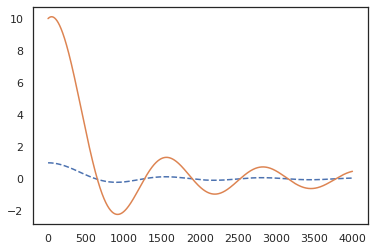

In [37]:
plt.plot(y_stress,'--');plt.plot(y_strain)

# DeepMoD

In [38]:
np.random.seed(42)  # setting seed for randomisation
noise_level = 0.0
number_of_samples = 2000

In [39]:
number_of_samples = 5000

idx = np.random.permutation(y_strain.size)
X_train = torch.tensor(t_v[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_strain[idx, :][:number_of_samples], dtype=torch.float32)


In [40]:
X_train.shape

torch.Size([4000, 1])

In [41]:
y_train.shape

torch.Size([4000, 1])

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

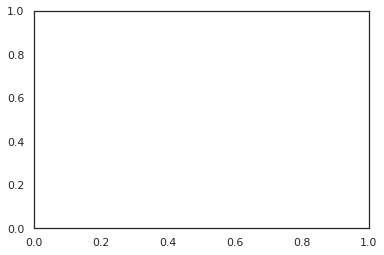

In [60]:
plt.scatter(X_train.squeeze(), y_train.squeeze())

In [42]:
optim_config = {'lambda': 10**-7, 'max_iterations': 10001}

In [43]:
network_config = {'input_dim': 1, 'hidden_dim': 20, 'layers': 1, 'output_dim': y_train.shape[1]}

In [44]:
library_config = {'type': mech_library_group}

In [45]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

1


In [47]:
train_group_mse(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 9.0E+00 9.0E+00
5000 9.8E-02 9.8E-02
10000 9.1E-02 9.1E-02


In [50]:
time_deriv_list, theta, coeff_vector_list = train_group(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config) 

Epoch | Total loss | MSE | PI | L1 
0 1.3E+02 4.0E-04 1.3E+02 9.4E-07 9.4E-07
tensor([[ 0.1773],
        [-1.4753],
        [-0.7677],
        [-0.5371],
        [-1.6694],
        [-0.2770],
        [-2.3813]], requires_grad=True)
5000 4.3E-02 2.8E-02 1.6E-02 2.1E-07 2.1E-07
tensor([[-1.9354e+00],
        [ 6.3343e+00],
        [-5.8372e-01],
        [-8.2862e-04],
        [ 2.0450e-01],
        [ 5.0390e-01],
        [-2.6132e-02]], requires_grad=True)
10000 2.4E-03 9.2E-04 1.5E-03 1.8E-07 1.8E-07
tensor([[-1.2397e+00],
        [ 1.0721e+01],
        [ 1.0819e+00],
        [-3.2386e-05],
        [-1.5153e-01],
        [ 1.5797e-01],
        [ 1.8728e-02]], requires_grad=True)


In [52]:
X_all = torch.tensor(t_v, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all).cpu()

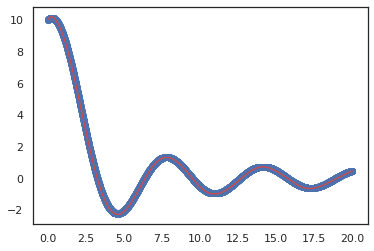

In [66]:
plt.scatter(t_v, y_strain)
plt.plot(t_v,prediction_full.detach().numpy(),'r')